In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index

from survivors.ensemble import BootstrapCRAID
import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [342]:
import numpy as np
from numba import njit

from scipy import stats
from survivors.tree.stratified_model import KaplanMeier, FullProbKM, NelsonAalen, KaplanMeierZeroAfter
from survivors.metrics import ibs_WW, auprc
from survivors.constants import get_y

""" Auxiliary functions """


@njit('f4(f4[:], f4[:], f4[:], f4[:], u4, f4[:])', cache=True)
def lr_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2,
                      weightings, obs_weights):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    
#     plt.plot(N_1_j)
#     plt.plot(N_2_j)
#     plt.show()
    
    # N_1_j = np.cumsum(time_hist_1)
    # N_2_j = np.cumsum(time_hist_2)
    ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j * N_2_j != 0))[0]
    # print(N_1_j[0], N_2_j[0], np.sum(cens_hist_1), np.sum(cens_hist_2))
    # print(N_1_j, N_2_j, cens_hist_1, cens_hist_2)
    # print(ind)
    if ind.shape[0] == 0:
        return 0.0

    N_1_j = N_1_j[ind]  # + 1
    N_2_j = N_2_j[ind]  # + 1
    O_1_j = cens_hist_1[ind]
    O_2_j = cens_hist_2[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j  # np.abs(O_1_j - E_1_j)
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))

    # res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))  # TODO
    # res[:, 2] = E_1_j * (N_j - O_j + 1) * (N_2_j + 1) / ((N_j + 1) * (N_j))
    res[:, 0] = 1.0
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 5:
        res[:, 0] = obs_weights[ind]
    elif weightings == 6:
        res[:, 0] = 1/N_j
    elif weightings == 7:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 8:
        res[:, 0] = N_j/(N_1_j*N_2_j)
        #res[:, 0] = np.cumprod((1.0 - O_1_j / (N_1_j + 1))) - np.cumprod((1.0 - O_2_j / (N_2_j + 1)))
    var = (res[:, 0] * res[:, 0] * res[:, 2]).sum()
    num = (res[:, 0] * res[:, 1]).sum()
    
    if var == 0:
        return 0
    stat_val = np.power(num, 2) / var  # ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
    
#     print("ALL:", N_j[0], "(", N_1_j[0], N_2_j[0], ")",
#           "OBS:", np.sum(O_j), "(", O_1_j, O_2_j, ")",  # ind,
#           "WEI:", res[:, 0],
#           # "OBS:", np.sum(O_j), "(", np.sum(cens_hist_1), np.sum(cens_hist_2), ")",
#           "STAT:", stat_val, "(", num, var, ")")

    if weightings == 7:
        res[:, 0] = 1 - res[:, 0]
        stat_val2 = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
        stat_val = max(stat_val, stat_val2)
    return stat_val  # It must be square of value (without sqrt)


def RMST_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2,
                      weightings, obs_weights, bins):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    
    sf_1 = np.cumprod((1.0 - cens_hist_1 / (N_1_j + 1)))
    sf_2 = np.cumprod((1.0 - cens_hist_2 / (N_2_j + 1)))
    
    sf_diff = sf_1 - sf_2
    stat_val = np.abs(np.sum(np.trapz(np.tril(np.ones((time_hist_1.shape[0], bins.shape[0])), k=0) * sf_diff, bins)))
    return stat_val


def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, weights_hist=None, weightings=""):
    try:
        if cens_hist_1 is None:
            cens_hist_1 = time_hist_1
        if cens_hist_2 is None:
            cens_hist_2 = time_hist_2
        if weights_hist is None:
            weights_hist = np.ones_like(time_hist_1)
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4, "weights": 5}
        d.update({"diff": 6, "maxcombo": 7, "frac": 8})
        weightings = d.get(weightings, 1)
        logrank = lr_hist_statistic(time_hist_1.astype("float32"),
                                    time_hist_2.astype("float32"),
                                    cens_hist_1.astype("float32"),
                                    cens_hist_2.astype("float32"),
                                    np.uint32(weightings),
                                    weights_hist.astype("float32"))
        return logrank
    except Exception as err:
        print(err)
        # print(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2, weights_hist)
        return 0.0

# def inverse_bincount_sf(time_hist, cens_hist):
#     evs = np.repeat(np.arange(1, time_hist.size + 1), cens_hist)
#     cns = np.repeat(np.arange(1, time_hist.size + 1), time_hist - cens_hist)
    
#     return get_y(time=np.hstack([evs, cns]),
#                cens=np.hstack([np.ones_like(evs), np.zeros_like(cns)]))

# def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, weights_hist=None, weightings=""):
#     y_1 = inverse_bincount_sf(time_hist_1.astype(int), cens_hist_1.astype(int))
#     y_2 = inverse_bincount_sf(time_hist_2.astype(int), cens_hist_2.astype(int))
#     y_gl = np.hstack([y_1, y_2])
    
#     N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
#     N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    
#     N_j = N_1_j + N_2_j
#     O_j = cens_hist_1 + cens_hist_2
#     sf_gl = np.cumprod((1.0 - O_j / (N_j + 1)))
#     sf_1 = np.cumprod((1.0 - cens_hist_1 / (N_1_j + 1)))
#     sf_2 = np.cumprod((1.0 - cens_hist_2 / (N_2_j + 1)))
    
#     sf_gl = np.repeat(sf_gl[np.newaxis, :], y_gl.shape[0], axis=0)
    
#     sf_1 = np.repeat(sf_1[np.newaxis, :], y_1.shape[0], axis=0)
#     sf_2 = np.repeat(sf_2[np.newaxis, :], y_2.shape[0], axis=0)
# #     print(sf_gl, y_gl)

# #     ibs_gl = metr.auprc(y_gl, y_gl, sf_gl, np.arange(time_hist_1.shape[0]))
#     ibs_1 = metr.ibs_WW(y_1, y_1, sf_1, np.arange(time_hist_1.shape[0]))
#     ibs_2 = metr.ibs_WW(y_2, y_2, sf_2, np.arange(time_hist_1.shape[0]))
# #     return ibs_gl - ibs_1 + ibs_2 # (ibs_1*y_1.shape[0] + ibs_2*y_2.shape[0])/y_gl.shape[0]
#     return - ibs_1*y_1.shape[0] + ibs_2*y_2.shape[0]
    
    

def optimal_criter_split_hist(left_time_hist, left_cens_hist,
                              right_time_hist, right_cens_hist,
                              na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef):
    none_to = 0
    max_stat_val = 1.0
    
    if int(dis_coef) > 1:
        dis_coef = int(dis_coef)
        left_time_hist = left_time_hist + (dis_coef - 1) * left_cens_hist
        right_time_hist = right_time_hist + (dis_coef - 1) * right_cens_hist
        na_time_hist = na_time_hist + (dis_coef - 1) * na_cens_hist

        left_cens_hist = left_cens_hist * dis_coef
        right_cens_hist = right_cens_hist * dis_coef
        na_cens_hist = na_cens_hist * dis_coef
    elif dis_coef != 0:
        if int(1/dis_coef) > 1:
            cens_dc = int(1/dis_coef)
            left_time_hist = (cens_dc - 1)*left_time_hist + left_cens_hist
            right_time_hist = (cens_dc - 1)*right_time_hist + right_cens_hist
            na_time_hist = (cens_dc - 1)*na_time_hist + (dis_coef - 1) * na_cens_hist

            left_cens_hist = left_cens_hist * cens_dc
            right_cens_hist = right_cens_hist * cens_dc
            na_cens_hist = na_cens_hist * cens_dc
    
    if na_time_hist.shape[0] > 0:
        a = weight_hist_stat(left_time_hist + na_time_hist, right_time_hist,
                             left_cens_hist + na_cens_hist, right_cens_hist,
                             weights_hist, weightings=criterion)
        b = weight_hist_stat(left_time_hist, right_time_hist + na_time_hist,
                             left_cens_hist, right_cens_hist + na_cens_hist,
                             weights_hist, weightings=criterion)
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
    #         print(a, b)
    else:
        max_stat_val = weight_hist_stat(left_time_hist, right_time_hist,
                                        left_cens_hist, right_cens_hist,
                                        weights_hist, weightings=criterion)
    return (max_stat_val, none_to)


def split_time_to_bins(time):
#     return np.searchsorted(np.quantile(time, np.arange(6)/5), time)
    return np.searchsorted(np.unique(time), time)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh, stat_diff=None):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    attrs["stat_diff"] = stat_diff 
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh + nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh + nan_sh, r_sh)
    return attrs


def transform_woe_np(x_feat, y):
    N_T = y.shape[0]
    N_D = y.sum()
    N_D_ = N_T - N_D
    x_uniq = np.unique(x_feat)
    x_dig = np.digitize(x_feat, x_uniq) - 1

    df_woe_iv = np.vstack([np.bincount(x_dig[y == 0], minlength=x_uniq.shape[0]),
                           np.bincount(x_dig[y == 1], minlength=x_uniq.shape[0])])
    all_0 = df_woe_iv[0].sum()
    all_1 = df_woe_iv[1].sum()

    p_bd = (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_bd_ = (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
    p_b_d = (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_b_d_ = (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

    woe_pl = np.log(p_bd / p_bd_)
    woe_mn = np.log(p_b_d / p_b_d_)
    descr_np = np.vstack([x_uniq, woe_pl - woe_mn])
    features_woe = dict(zip(descr_np[0], descr_np[1]))
    woe_x_feat = np.vectorize(features_woe.get)(x_feat)
    # calculate information value
    # iv = ((p_bd - p_bd_)*woe_pl).sum()
    return (woe_x_feat, descr_np)


def get_sa_hists(time, cens, minlength=1, weights=None):
    if time.shape[0] > 0:
        time_hist = np.bincount(time, minlength=minlength)
        cens_hist = np.bincount(time, weights=cens, minlength=minlength)
#         time_hist = np.bincount(time, weights=weights, minlength=minlength)
#         cens_hist = np.bincount(time, weights=cens*weights, minlength=minlength)
    else:
        time_hist, cens_hist = np.array([]), np.array([])
    return time_hist, cens_hist


def select_best_split_info(attr_dicts, type_attr, bonf=True, descr_woe=None):
    attr_dicts = sorted(attr_dicts, key=lambda x: abs(x["stat_diff"]), reverse=True)[:max(1, len(attr_dicts)//2)]
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
#     plt.scatter([d["values"] for d in attr_dicts], [d["stat_val"] for d in attr_dicts])
#     plt.vlines([best_attr["values"]], ymin=0, ymax=best_attr["stat_val"], color="orange")
#     plt.show()
    
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        best_attr["src_val"] = best_attr['values']
        if type_attr == "cont":
            best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
        # elif type_attr == "categ":
        #     best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
        elif type_attr == "woe" or type_attr == "categ":
            ind = descr_woe[1] <= best_attr["values"]
            l, r = list(descr_woe[0, ind]), list(descr_woe[0, ~ind])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
    return best_attr

def ranksums_hist(x, y):
    n1 = np.sum(x)
    n2 = np.sum(y)
    rank = np.arange(1, x.shape[0] + 1)
    s = np.dot(x, rank)
#     print(s)
    expected = n1 * (n1+n2+1) / 2.0
    z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
    return z

def mw_hist(x, y):
    n1 = np.sum(x)
    n2 = np.sum(y)
    rank = np.arange(1, x.shape[0] + 1)
    R1 = np.dot(x, rank)
    U1 = R1 - n1*(n1+1)/2
    U2 = n1 * n2 - U1

    U = np.maximum(U1, U2)
    return U

# def ranksums(x, y):
#     x, y = map(np.asarray, (x, y))
#     n1 = x.shape[0]
#     n2 = y.shape[0]
#     alldata = np.concatenate((x, y))
#     ranked = rankdata(alldata)
#     x = ranked[:n1]
#     s = np.sum(x, axis=0)
# #     print(s)
#     expected = n1 * (n1+n2+1) / 2.0
#     z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
#     return z

def hist_best_attr_split(arr, criterion="logrank", type_attr="cont", weights=None, thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, balance=False, **kwargs):
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2 * min_samples_leaf:
        return best_attr
    vals = arr[0].astype("float")
    cens = arr[1].astype("uint")
    dur = arr[2].astype("float")
    
    if np.sum(cens) == 0:
#         cens = np.ones_like(dur)
        return best_attr
    if weights is None:
        weights = np.ones_like(dur)
        '''
        kmf = KaplanMeierZeroAfter()
        kmf.fit(dur, cens)
        dd = np.unique(dur)
        sf = kmf.survival_function_at_times(dd)
        sf = np.repeat(sf[np.newaxis, :], dur.shape[0], axis=0)

        y = get_y(cens=cens, time=dur)
        weights = ibs_WW(y, y, sf, dd, axis=0)
        '''
        
    weights_hist = None
    dur = split_time_to_bins(dur)
    max_bin = dur.max()

    ind = np.isnan(vals)

    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]
    weights_notna = weights[~ind]

    dis_coef = 1
    if balance:
        dis_coef = (cens.shape[0] - np.sum(cens)) / np.sum(cens)
        # dis_coef = max(1, (cens.shape[0] - np.sum(cens)) // np.sum(cens))

    if dur_notna.shape[0] < min_samples_leaf:
        return best_attr

    descr_woe = None
    if type_attr == "woe" or type_attr == "categ":
        vals_notna, descr_woe = transform_woe_np(vals_notna, cens_notna)

    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i / float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:]) * 0.5
    uniq_set = np.unique(np.round(uniq_set, 3))

    index_vals_bin = np.digitize(vals_notna, uniq_set, right=True)

    # find global hist by times
    na_time_hist, na_cens_hist = get_sa_hists(dur[ind], cens[ind],
                                              minlength=max_bin + 1, weights=weights[ind])

    r_time_hist, r_cens_hist = get_sa_hists(dur_notna, cens_notna,
                                            minlength=max_bin + 1, weights=weights_notna)
    l_time_hist = np.zeros_like(r_time_hist, dtype=np.float32)
    l_cens_hist = l_time_hist.copy()

    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0

    if criterion == "confident" or criterion == "confident_weights":
        kmf = KaplanMeier()
        if criterion == "confident_weights":
            kmf.fit(dur, cens, weights=weights)
        else:
            kmf.fit(dur, cens)
        ci = kmf.get_confidence_interval_()
        weights_hist = 1 / (ci[1:, 1] - ci[1:, 0] + 1)  # (ci[1:, 1] + ci[1:, 0] + 1e-5)
        criterion = "weights"
    elif criterion == "fullprob":
        kmf = FullProbKM()
        kmf.fit(dur, cens)
        weights_hist = kmf.survival_function_at_times(np.unique(dur))
        criterion = "weights"
    elif criterion == "ibswei":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        sf = kmf.survival_function_at_times(dd)
        sf = np.repeat(sf[np.newaxis, :], dd.shape[0], axis=0)

        y_ = get_y(cens=np.ones_like(dd), time=dd)
        y_["cens"] = True
        ibs_ev = ibs_WW(y_, y_, sf, dd, axis=0)
        y_["cens"] = False
        ibs_cn = ibs_WW(y_, y_, sf, dd, axis=0)

        ratio = np.sum(cens)/cens.shape[0]
        weights_hist = ibs_ev*ratio + ibs_cn*(1-ratio)
        criterion = "weights"
    elif criterion == "T-ET":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        ET = np.trapz(kmf.survival_function_at_times(dd), dd)
        weights_hist = (dd - ET)  # **2
        criterion = "weights"
    elif criterion == "kde":
        na = NelsonAalen()
        na.fit(dur, cens, np.ones(len(dur)))
        weights_hist = na.get_smoothed_hazard_at_times(np.unique(dur))
        criterion = "weights"
    elif criterion == "weights":
        weights_hist = np.bincount(dur, weights=weights,  # /sum(weights),
                                   minlength=max_bin + 1)
        #weights_hist /= np.bincount(dur, minlength=max_bin + 1)  # np.sqrt()
        weights_hist = np.cumsum(weights_hist[::-1])[::-1]  # np.sqrt()

        weights_hist = weights_hist / weights_hist.sum()

    # for each split values get branches
    attr_dicts = []
    
#     min_times = []
#     stat_vals = []
    for u in np.unique(index_vals_bin)[:-1]:
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist, curr_cens_hist = get_sa_hists(dur_notna[curr_mask], cens_notna[curr_mask],
                                                      minlength=max_bin + 1, weights=weights_notna[curr_mask])
        l_time_hist += curr_time_hist
        l_cens_hist += curr_cens_hist
        r_time_hist -= curr_time_hist
        r_cens_hist -= curr_cens_hist
        num_l += curr_n
        num_r -= curr_n

        if min(num_l, num_r) <= min_samples_leaf:
            continue
        
        max_stat_val, none_to = optimal_criter_split_hist(
            l_time_hist, l_cens_hist, r_time_hist, r_cens_hist,
            na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef)
#         t1 = np.max(np.nonzero(l_time_hist))
#         t2 = np.max(np.nonzero(r_time_hist))
#         min_times.append(min(t1, t2))
#         stat_vals.append(max_stat_val)
        
        if max_stat_val > signif_stat:
#             times_1 = np.repeat(np.arange(1, l_time_hist.size + 1), l_time_hist.astype(int))
#             times_2 = np.repeat(np.arange(1, r_time_hist.size + 1), r_time_hist.astype(int))
#             stat_diff = ranksums(times_1, times_2)[0]
            if na_time_hist.shape[0] > 0:
                stat_diff = mw_hist((l_time_hist + (1 - none_to)*na_time_hist), 
                                    (r_time_hist + none_to*na_time_hist))
            else:
                stat_diff = mw_hist(l_time_hist,
                                    r_time_hist)

#             print(stat_diff1, stat_diff)
            
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan, stat_diff)
            attr_dicts.append(attr_loc)
            
#     plt.scatter(min_times, stat_vals)
#     plt.show()
    if len(attr_dicts) == 0:
        return best_attr
    best_attr = select_best_split_info(attr_dicts, type_attr, bonf, descr_woe=descr_woe)
    
#     plt.plot(weights_hist)
#     plt.show()
    
    '''
    fig, axes = plt.subplots(ncols=2)
    axes[0].plot(np.cumsum((l_time_hist + r_time_hist)[::-1])[::-1])
    axes[1].plot(l_cens_hist + r_cens_hist)
    axes[1].plot(l_time_hist + r_time_hist - (l_cens_hist + r_cens_hist), color="orange")
    plt.show()
    '''
    
    '''
    fig, axes = plt.subplots(ncols=2)
    cols = np.where(vals_notna <= best_attr["src_val"], "blue", "orange")
    axes[1].scatter(vals_notna, weights_notna, c=cols)
    axes[0].scatter(dur_notna, weights_notna, c=cols)
    plt.show()
    '''
    
    if verbose > 0:
        print(best_attr["p_value"], len(uniq_set))
    return best_attr

In [343]:
from survivors.tree.node import Node, Rule
from survivors.tree import CRAID

class Node1(Node):
    def find_best_split(self):
        numb_feats = self.info["max_features"]
        numb_feats = np.clip(numb_feats, 1, len(self.features))
        n_jobs = min(numb_feats, self.info["n_jobs"])

        selected_feats = list(np.random.choice(self.features, size=numb_feats, replace=False))
        # args = self.get_comb(selected_feats)
        args = self.get_comb_fast(selected_feats)

        ml = np.vectorize(lambda x: hist_best_attr_split(**x))(args)

        # with Parallel(n_jobs=n_jobs, verbose=self.verbose, batch_size=10) as parallel:  # prefer="threads"
        #     ml = parallel(delayed(hist_best_attr_split)(**a) for a in args)  # hist_best_attr_split
        attrs = {f: ml[ind] for ind, f in enumerate(selected_feats)}

# #         attr = min(attrs, key=lambda x: attrs[x]["p_value"])
        attr = max(attrs, key=lambda x: attrs[x]["stat_val"])
        
#         print("STAT_VAL:", [v["stat_val"] for k, v in attrs.items()])
#         print("SIGN_SPLIT:", [v["sign_split"] for k, v in attrs.items()])
#         print("P_VALUES:", [v["p_value"] for k, v in attrs.items()])
        
#         attrs_gr = dict(filter(lambda x: x[1]["sign_split"] > 0, attrs.items()))
#         if len(attrs_gr) == 0:
#             attr = min(attrs, key=lambda x: attrs[x]["p_value"])
#         else:
#             attr = min(attrs_gr, key=lambda x: attrs_gr[x]["p_value"])
#             if self.info["bonf"]:
#                 attrs[attr]["p_value"] = attrs[attr]["p_value"] / attrs[attr]["sign_split"]
            
#         if attrs[attr]["sign_split"] > 0 and self.info["bonf"]:
#             attrs[attr]["p_value"] = attrs[attr]["p_value"] / attrs[attr]["sign_split"]
        return (attr, attrs[attr])
    
    def split(self):
#         print("TIME:", self.df[cnt.TIME_NAME].to_numpy())
#         print("TIME:", self.df[cnt.CENS_NAME].to_numpy())
#         bins = cnt.get_bins(time=self.df[cnt.TIME_NAME].to_numpy(),
#                             cens=self.df[cnt.CENS_NAME].to_numpy())
#         y__ = cnt.get_y(cens=self.df[cnt.CENS_NAME].to_numpy(), 
#                         time=self.df[cnt.TIME_NAME].to_numpy())
#         sf = self.predict(self.df, target="surv", bins=bins)
        
#         print(f"NODE {self.numb}:", metr.ibs_remain(y__, y__, sf, bins))
        
        node_edges = np.array([], dtype=int)
        self.rule_edges = np.array([], dtype=Rule)
        
        attr, best_split = self.find_best_split()
        
        # The best split is not significant
        if best_split["sign_split"] == 0:
            if self.verbose > 0:
                print(f'Конец ветви, незначащее p-value: {best_split["p_value"]}')
            return node_edges
        if self.verbose > 0:
            print('='*6, best_split["p_value"], attr)

        branch_ind = self.ind_for_nodes(self.df[attr], best_split, attr in self.categ)

        for n_b in np.unique(branch_ind):
            rule = Rule(feature=attr,
                        condition=best_split["values"][n_b],
                        has_nan=best_split["pos_nan"][n_b])
            d_node = self.df[branch_ind == n_b].copy()
            N = Node1(df=d_node, full_rule=self.full_rule + [rule],
                     features=self.features, categ=self.categ,
                     depth=self.depth + 1, verbose=self.verbose, **self.info)
            node_edges = np.append(node_edges, N)
            self.rule_edges = np.append(self.rule_edges, rule)

        if self.rule_edges.shape[0] == 1:
            print(branch_ind, self.df[attr], best_split, attr in self.categ)
            raise ValueError('ERROR: Only one branch created!')

        return node_edges

class CRAID1(CRAID):
    def fit(self, X, y):
        if len(self.features) == 0:
            self.features = X.columns
        self.bins = cnt.get_bins(time=y[cnt.TIME_NAME])  # , cens = y[cnt.CENS_NAME])
        X = X.reset_index(drop=True)
        X_tr = X.copy()
        X_tr[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X_tr[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        if not ("min_samples_leaf" in self.info):
            self.info["min_samples_leaf"] = 0.01
        if isinstance(self.info["min_samples_leaf"], float):
            self.info["min_samples_leaf"] = max(int(self.info["min_samples_leaf"] * X_tr.shape[0]), 1)

        cnt.set_seed(self.random_state)

        if self.balance in ["balance", "balance+correct"]:
            freq = X_tr[cnt.CENS_NAME].value_counts()
            self.correct_proba = freq[1] / (freq[1] + freq[0])  # or freq[1] / (freq[0])

            X_tr = get_oversample(X_tr, target=cnt.CENS_NAME)
        elif self.balance in ["balance+weights"]:
            freq = X_tr[cnt.CENS_NAME].value_counts()

            X_tr["weights_obs"] = np.where(X_tr[cnt.CENS_NAME], freq[0] / freq[1], 1)
            self.info["weights_feature"] = "weights_obs"
        elif self.balance in ["only_log_rank"]:
            self.info["balance"] = True

        if self.cut:
            X_val = X_tr.sample(n=int(0.2 * X_tr.shape[0]), random_state=self.random_state)
            X_tr = X_tr.loc[X_tr.index.difference(X_val.index), :]

        self.nodes[0] = Node1(X_tr, features=self.features, categ=self.categ, **self.info)
        stack_nodes = np.array([0], dtype=int)
        while stack_nodes.shape[0] > 0:
            node = self.nodes[stack_nodes[0]]
            stack_nodes = stack_nodes[1:]
            if node.depth >= self.depth:
                continue
            sub_nodes = node.split()
            if sub_nodes.shape[0] > 0:
                sub_numbers = np.array([len(self.nodes) + i for i in range(sub_nodes.shape[0])])
                for i in range(sub_nodes.shape[0]):
                    sub_nodes[i].numb = sub_numbers[i]
                self.nodes.update(dict(zip(sub_numbers, sub_nodes)))
                node.set_edges(sub_numbers)
                stack_nodes = np.append(stack_nodes, sub_numbers)

        if self.cut:
            self.cut_tree(X_val, cnt.CENS_NAME, mode_f=roc_auc_score, choose_f=max)

        # self.fit_cox_hazard(X, y)
        return

In [344]:
class BootstrapCRAID1(BootstrapCRAID):
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.y_train = y
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]

            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_cr = cnt.pd_to_xy(x_sub)

            model = CRAID1(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_cr)

            self.add_model(model, x_oob)
        print(f"fitted: {len(self.models)} models.")

In [345]:
from survivors.ensemble import BoostingCRAID

class IBSCleverBoostingCRAID1(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"

    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y

        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, 
                                        weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print(f"UNIQUE ({i}):{np.unique(x_sub.index).shape[0]}, DIST:", np.bincount(x_sub["cens"]))
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']]
            
#             plt.scatter(y_sub_tr["time"], self.weights[x_sub['ind_start']])
#             plt.show()
            
            model = CRAID1(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)

            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)

    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))

        res = np.array(res)
        weights = None # np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))

        res = np.array(res)
        weights = None # np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
            if mode == "surv":
                res[:, -1] = 0
                res[:, 0] = 1
        return res

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        # PRED WEI!!!
#         ibs_sf = metr.ibs_WW(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        
#         if len(self.bettas) > 0:
#             pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
#             ibs_ens = metr.ibs_WW(self.y_train, y_sub, pred_ens, self.bins)
#             betta = ibs_ens / np.mean(ibs_sf)
#         else:
#             betta = 1
#         wei = ibs_sf
        
        ibs_sf = metr.auprc(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        betta = np.mean(ibs_sf)
        wei = 1 - ibs_sf
#         if len(self.bettas) > 0:
#             pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
            
#             ibs_ens = metr.ibs_WW(self.y_train, y_sub, pred_ens, self.bins)
            
#             betta = ibs_ens / np.mean(ibs_sf)
#             # betta = ibs_ens / np.mean(ibs_sf)
#             print(betta, np.mean(ibs_sf), np.std(ibs_sf))
#             wei = (ibs_ens + (betta**2) * ibs_sf)/(1+ betta)**2
#         else:
#             betta = 1
#             wei = ibs_sf
        return wei, abs(betta)

    def update_weight(self, index, wei_i):
        # PRED WEI!!!
#         if len(self.models) > 1:
#             self.weights = self.weights + (self.bettas[-1]**2) * wei_i
#             self.weights /= (1 + self.bettas[-1])**2
#             self.bettas = list(np.array(self.bettas)/np.sum(self.bettas))
#         else:
#             self.weights = wei_i
        self.weights += wei_i

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
            if wei is None:
                wei = np.array(self.bettas)
            wei = wei / np.sum(wei)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argmean":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1, 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argwei":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1/np.array(self.bettas), 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        return np.mean(x, axis=0)

    def plot_curve(self, X_tmp, y_tmp, bins, label="", metric="ibs"):
        res = []
        metr_vals = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="surv"))

            res_all = np.array(res)
            res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
            res_all[:, -1] = 0
            res_all[:, 0] = 1
            if metric == "ibs":
                metr_vals.append(metr.ibs_WW(self.y_train, y_tmp, res_all, bins))
            else:
                metr_vals.append(metr.auprc(self.y_train, y_tmp, res_all, bins))
        plt.plot(range(len(self.models)), metr_vals, label=label)

In [346]:
from survivors.ensemble import BoostingCRAID

class IBSCRAID1(CRAID1):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ibs_leaf = None

    def set_ibs_by_leaf(self, X, y):
        numbs = self.predict(X, target="numb").astype("int")
        
        sf = self.predict_at_times(X, bins=self.bins, mode="surv")
        ibs_ex = metr.auprc(y, y, sf, self.bins, axis=0)
        
        counts = np.bincount(numbs)
        self.ibs_leaf = np.bincount(numbs, weights=ibs_ex)
        self.ibs_leaf[counts > 0] /= counts[counts > 0]

    def get_ibs_by_leaf(self, X):
        numbs = self.predict(X, target="numb").astype("int")
        return self.ibs_leaf[numbs]

    def fit(self, X, y):
        super().fit(X, y)
        # self.set_ibs_by_leaf(X, y)

class IBSCleverBoostingCRAID1(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"

    def fit(self, X, y):
        self.features = list(X.columns)
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X.copy()
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y

        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, 
                                        # weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print(f"UNIQUE ({i}):{np.unique(x_sub.index).shape[0]}, DIST:", np.bincount(x_sub["cens"]))
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']].copy()
#                 if len(self.bettas) > 0:
#                     X_sub_tr["weights_obs"] /= np.sum(self.bettas)
            
#             print(np.sum(self.bettas))
#             if len(self.bettas) > 0:
#                 plt.scatter(self.X_train["time"], self.weights / np.sum(self.bettas), 
#                             c=np.where(self.X_train["cens"], "orange", "blue"))
#                 plt.show()
#             else:
            plt.scatter(self.X_train["time"], self.weights, 
                        c=np.where(self.X_train["cens"], "orange", "blue"))
            plt.show()
                
            
            model = IBSCRAID1(features=self.features.copy(), random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)

            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)
            #self.X_train[f"ibs_feature_{i}"] = model.get_ibs_by_leaf(self.X_train)
            #self.features.append(f"ibs_feature_{i}")

    def predict(self, x_test_, aggreg=True, **kwargs):
        res = []
        weights = []
        x_test = x_test_.copy()
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))
            # x_test[f"ibs_feature_{i}"] = self.models[i].get_ibs_by_leaf(x_test)

        res = np.array(res)
        weights = None # np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def predict_at_times(self, x_test_, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        x_test = x_test_.copy()
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))
            # x_test[f"ibs_feature_{i}"] = self.models[i].get_ibs_by_leaf(x_test)

        res = np.array(res)
        weights = None # np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
            if mode == "surv":
                res[:, -1] = 0
                res[:, 0] = 1
        return res

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        # PRED WEI!!!
        y_sub_ = y_sub.copy()
#         y_sub_["cens"] = 1
        ibs_sf = metr.ibs_remain(self.y_train, y_sub_, pred_sf, self.bins, axis=0)
        
#         if len(self.bettas) > 0:
#             pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
#             ibs_ens = metr.ibs_WW(self.y_train, y_sub, pred_ens, self.bins)
#             betta = ibs_ens / np.mean(ibs_sf)
#         else:
#             betta = 1
#         wei = ibs_sf

#         if len(self.bettas) > 0:
#             pred_ens = self.predict_at_times(X_sub, bins=self.bins, mode="surv")
            
#             ibs_ens = metr.ibs_WW(self.y_train, y_sub, pred_ens, self.bins)
            
#             betta = ibs_ens / np.mean(ibs_sf)
#             # betta = ibs_ens / np.mean(ibs_sf)
#             print(betta, np.mean(ibs_sf), np.std(ibs_sf))
#             wei = (ibs_ens + (betta**2) * ibs_sf)/(1+ betta)**2
#         else:
        wei = ibs_sf
        # wei = self.weights * ibs_sf / np.sum(self.weights)
        betta = 1/np.mean(ibs_sf)
        return wei, abs(betta)

    def update_weight(self, index, wei_i):
        # PRED WEI!!!
#         if len(self.models) > 1:
#             self.weights = self.weights + (self.bettas[-1]**2) * wei_i
#             self.weights /= (1 + self.bettas[-1])**2
#             self.bettas = list(np.array(self.bettas)/np.sum(self.bettas))
#         else:
#             self.weights = wei_i

        if len(self.models) > 1:
            self.weights += (self.bettas[-1]) * wei_i
        else:
            self.weights = (self.bettas[-1]) * wei_i
        # self.weights = 1 + (wei_i > (len(self.models) / np.sum(self.bettas)))

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
            if wei is None:
                wei = np.array(self.bettas)
            wei = wei / np.sum(wei)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argmean":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1, 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argwei":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1/np.array(self.bettas), 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        return np.mean(x, axis=0)

    def plot_curve(self, X_tmp, y_tmp, bins, label="", metric="ibs"):
        res = []
        metr_vals = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="surv"))

            res_all = np.array(res)
            res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
            res_all[:, -1] = 0
            res_all[:, 0] = 1
            if metric == "ibs":
                metr_vals.append(metr.ibs_WW(self.y_train, y_tmp, res_all, bins))
            else:
                metr_vals.append(metr.auprc(self.y_train, y_tmp, res_all, bins))
        plt.plot(range(len(self.models)), metr_vals, label=label)

In [347]:
from survivors.ensemble import BoostingCRAID

class IBSCleverBoostingCRAID1(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"

    def fit(self, X, y):
        self.features = list(X.columns)
        X = X.reset_index(drop=True).copy()
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X.copy()
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y.copy()

        self.weights = y[cnt.TIME_NAME].copy()
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()
        self.lr = 1

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, 
                                        # weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print(f"UNIQUE ({i}):{np.unique(x_sub.index).shape[0]}, DIST:", np.bincount(x_sub["cens"]))
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub.copy())
            y_sub_tr[cnt.TIME_NAME] = self.weights[x_sub['ind_start'].values].copy()
            print("TIME CONC:", concordance_index(x_sub[cnt.TIME_NAME], y_sub_tr[cnt.TIME_NAME]))
            
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']].copy()
                
            plt.scatter(self.y_train["time"], self.weights, c=np.where(self.y_train["cens"], "orange", "blue"))
            plt.show()
            
            model = IBSCRAID1(features=self.features.copy(), random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)

            wei_i, betta_i = self.count_model_weights(model, X_sub_tr.copy(), y_sub_tr.copy())
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'].values, wei_i)

    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))

        res = np.array(res)
        weights = None
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))

        res = np.array(res)
        weights = None
        if aggreg:
            res = self.get_aggreg(res, weights)
            if mode == "surv":
                res[:, -1] = 0
                res[:, 0] = 1
        return res
            
#     def count_model_weights(self, model, X_sub, y_sub):
#         if self.all_weight:
#             X_sub = self.X_train.copy()
#             y_sub = self.y_train.copy()
#         pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
            
#         y_sub["time"] = self.weights[X_sub['ind_start'].values]
#         ind = np.digitize(y_sub["time"], self.bins) - 1
#         sf_by_time = np.take_along_axis(pred_sf, ind[:, np.newaxis], axis=1).reshape(-1)
        
#         wei = 20 * ((1 - sf_by_time)**2 - y_sub["cens"] * sf_by_time**2)
#         betta = self.lr
#         return wei, abs(betta)
    
    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train.copy()
            y_sub = self.y_train.copy()
        y_sub_ = y_sub.copy()
#         pred_time = model.predict(X_sub, target="time")
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
            
        y_sub["time"] = self.weights[X_sub['ind_start'].values]
        pred_time = self.bins[(pred_sf <= 0.5).argmax(axis=1)]
        ibs_sf = metr.ibs_remain(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        
        wei = (y_sub["time"] - pred_time) * ibs_sf**2
        betta = self.lr/np.mean(ibs_sf)
        return wei, abs(betta)

    def update_weight(self, index, wei_i):
#         print(index, wei_i)
        self.lr = 0.3
        if self.all_weight:
            self.weights -= wei_i * self.lr
        else:
            self.weights[index] -= wei_i * self.lr
            
    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
            if wei is None:
                wei = np.array(self.bettas)
            wei = wei / np.sum(wei)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argmean":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1, 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argwei":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1/np.array(self.bettas), 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        return np.mean(x, axis=0)

    
    def plot_curve(self, X_tmp, y_tmp, bins, label="", metric="ibs", axes=None):
        print(label)
        res = []
        metr_vals = []
        q = [0.05, 0.25, 0.5, 0.75, 0.95]
        quantiles = []
        
        for i in range(len(self.models)):
            if metric == "IAUC_WW_TI":
                res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="hazard"))
                res_all = np.array(res)
                res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
                
                metr_vals.append(metr.iauc_WW_TI(self.y_train, y_tmp, res_all, bins))
            elif metric == "CI_CENS":
                res.append(self.models[i].predict(X_tmp, target="time"))
                res_all = np.array(res)
                res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])

                metr_vals.append(concordance_index(y_tmp[cnt.TIME_NAME], res_all, y_tmp[cnt.CENS_NAME]))
            else:
                res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="surv"))
                res_all = np.array(res)
                res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
                res_all[:, -1] = 0
                res_all[:, 0] = 1

                if metric == "AUPRC":
                    metr_by_obs = metr.auprc(self.y_train, y_tmp, res_all, bins, axis=0)
                    metr_vals.append(metr.auprc(self.y_train, y_tmp, res_all, bins))
                elif metric == "ibs_WW":
                    metr_by_obs = metr.ibs_WW(self.y_train, y_tmp, res_all, bins, axis=0)
                    metr_vals.append(metr.ibs_WW(self.y_train, y_tmp, res_all, bins))
                elif metric == "ibs_REMAIN":
                    metr_by_obs = metr.ibs_remain(self.y_train, y_tmp, res_all, bins, axis=0)
                    metr_vals.append(metr.ibs_remain(self.y_train, y_tmp, res_all, bins))
                quantiles.append(np.quantile(metr_by_obs, q))
        
        if axes is None:
            fig, axes = plt.subplots(ncols=2)
            axes[0].plot(range(len(self.models)), metr_vals, label=label)
            axes[1].plot(np.hstack([quantiles]), label=q)
            axes[1].legend()
        else:
            plt.plot(range(len(self.models)), metr_vals, label=label)
            plt.xlabel("Size of ensemble")
            plt.ylabel(metric)

In [348]:
from sklearn.model_selection import train_test_split
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric


# def get_bins(time, cens=None, mode='a', num_bins=100):
#     if not(cens is None):
#         time = time[np.where(cens)]
#     time = time.astype(np.int32)
#     bins = np.array([])
#     if mode == 'q':
#         bins = np.quantile(time, np.arange(num_bins) / num_bins)
#     elif mode == 'a':
# #         bins = np.arange(time.min(), time.max()+1)  # all bins
#         bins = np.unique(np.quantile(time, np.arange(2.5, 97.5) / 100)) 
# #         t_max = np.quantile(time, 0.95)  # NEW
# #         bins = np.arange(time.min(), t_max)  # NEW
#     return bins

# def prepare_sample(X, y, train_index, test_index):
#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
#     y_train, y_test = y[train_index], y[test_index]
    
#     bins = get_bins(time=y_train[cnt.TIME_NAME], cens=y_train[cnt.CENS_NAME], mode='q')
# #     y_train[cnt.TIME_NAME] = np.clip(y_train[cnt.TIME_NAME], bins.min() - 1, bins.max() + 1)

#     y_test[cnt.TIME_NAME] = np.clip(y_test[cnt.TIME_NAME], bins.min(), bins.max())
#     return X_train, y_train, X_test, y_test, bins

# X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X, y, features, categ, sch_nan = ds.load_wuhan_dataset()
# y["time"] += 1

# y["cens"] = ~y["cens"]
features = list(set(features) - {"max_2019_nCoV_nucleic_acid_detection", 
                                 "mean_2019_nCoV_nucleic_acid_detection", 
                                 "min_2019_nCoV_nucleic_acid_detection"})
X = X[features]

X_TR, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME],
                              test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['max_' + c] = df_agg[c].apply(np.nanmax)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + 

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mi

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1076: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\other.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

In [349]:
kmf = KaplanMeierZeroAfter()
kmf.fit(y[X["sex"] == 0]["time"], 1 - y[X["sex"] == 0]["cens"])
plt.step(bins_HO,  -np.log(kmf.survival_function_at_times(bins_HO)))

kmf = KaplanMeierZeroAfter()
kmf.fit(y[X["sex"] == 1]["time"], 1 - y[X["sex"] == 1]["cens"])
plt.step(bins_HO,  -np.log(kmf.survival_function_at_times(bins_HO)))

KeyError: 'sex'

In [ ]:
from lifelines import CoxPHFitter

# ff = list(set(df.columns) - set(["mean_basophil_count___", "min_basophil_count___", "max_basophil_count___", 
#                                  "mean_basophil___", "min_basophil___", "max_basophil___",
#                                  "max_HCV_antibody_quantification", "min_HCV_antibody_quantification", "mean_HCV_antibody_quantification",
#                                  "max_HIV_antibody_quantification", "min_HIV_antibody_quantification", "mean_HIV_antibody_quantification"]))
df_ = df.fillna(0).replace(np.nan, 0)
cph = CoxPHFitter(penalizer=0.01).fit(df_, 'time', 'cens')
# axes = cph.check_assumptions(df_, p_value_threshold=0.1)
cph.print_summary()

In [ ]:
-207.42

Concordance	1.00
Partial AIC	856.84
log-likelihood ratio test	67.89 on 221 df
-log2(p) of ll-ratio test	-0.00

In [ ]:
from survivors.tree import CRAID
from survivors.tree.node import Node

tree = Node(df, features=features, criterion="logrank", depth=10, min_samples_leaf=2)

In [ ]:
tree.info

In [ ]:
kmf = KaplanMeierZeroAfter()
kmf.fit(y["time"], y["cens"])

dd = np.unique(y["time"])
sf = kmf.survival_function_at_times(dd)
sf = np.repeat(sf[np.newaxis, :], y.shape[0], axis=0)

ibs_full = ibs_WW(y, y, sf, dd, axis=0)

y_ = y.copy()
y_["cens"] = True
ibs_ev = ibs_WW(y, y_, sf, dd, axis=0)
y_["cens"] = False
ibs_cn = ibs_WW(y, y_, sf, dd, axis=0)

ratio = np.sum(y["cens"])/y.shape[0]
weights_hist = ibs_ev*ratio + ibs_cn*(1-ratio)

In [ ]:
plt.plot(np.sort(y["time"]), ibs_ev[np.argsort(y["time"])])

In [ ]:
n_w = np.cumsum(np.bincount(y["time"].astype(int), weights=ibs_ev)[::-1])[::-1]
o_w = np.bincount(y["time"].astype(int), weights=ibs_ev)

n_j = np.cumsum(np.bincount(y["time"].astype(int))[::-1])[::-1]
o_j = np.bincount(y["time"].astype(int))

# plt.plot(n_w)
# plt.plot(n_j)

# plt.plot(n_w/n_j)
# plt.plot(o_w[o_w>0]/o_j[o_w>0])

plt.plot(np.bincount(y["time"].astype(int)))
plt.plot(np.bincount(y["time"].astype(int), weights=ibs_ev))

In [ ]:
def ind_for_nodes(X_attr, best_split_, is_categ):
    rule_id = best_split_["pos_nan"].index(0)
    query = best_split_["values"][rule_id]
    if is_categ:
        values = np.isin(X_attr, eval(query[query.find("["):]))
    else:
        values = eval("X_attr" + query)
    return np.where(values, rule_id, 1 - rule_id)

def fit_predict_KM(X_):
    y_ = get_y(time=X_[-1], cens=X_[-2])
#     print(y_["time"])
    kmf = KaplanMeierZeroAfter()
    kmf.fit(y_["time"], y_["cens"])
    sf = kmf.survival_function_at_times(bins_HO)
    sf = np.repeat(sf[np.newaxis, :], y_.shape[0], axis=0)
    print(f"IBS:{ibs_WW(y_, y_, sf, bins_HO):.5f}, AUPRC:{auprc(y_, y_, sf, bins_HO):.5f}, {X_.shape[1]}")

def get_ibs(X_, best_split_, f, is_categ):
    fit_predict_KM(X_)
    inds = ind_for_nodes(X_[f], best_split_, is_categ)
    fit_predict_KM(X_[:, np.where(inds == 0)[0]])
    fit_predict_KM(X_[:, np.where(inds == 1)[0]])

In [ ]:
n1 = np.arange(1, 100)
plt.plot((n1*(100-n1))/100)

In [ ]:
X_ = df.loc[:, features + [cnt.CENS_NAME, cnt.TIME_NAME]].to_numpy().T
for i_w, w in enumerate([np.ones(X_.shape[1]), ibs_full, weights_hist]):
    attr_by = {}
    for i_f, f in enumerate(features):
        d = tree.info.copy()
        d["arr"] = np.vstack((X_[i_f], X_[-2:]))
        d["type_attr"] = ("woe" if tree.woe else "categ") if f in tree.categ else "cont"
        d["weights"] = w
        a = hist_best_attr_split(**d)
        #print(f, w[:5], a)
        #get_ibs(X_, a, i_f, d["type_attr"] == "categ")
        attr_by[f] = a

    attr = max(attr_by, key=lambda x: attr_by[x]["stat_val"])
    print(attr, "BEST FEATURE")
    get_ibs(X_, attr_by[attr], features.index(attr), attr in tree.categ)

In [ ]:
from survivors.tree.stratified_model import KaplanMeier, FullProbKM, NelsonAalen, KaplanMeierZeroAfter

y_sub = y[:100].copy()

kmf1 = KaplanMeierZeroAfter()
kmf1.fit(y_sub["time"], y_sub["cens"])

dd = np.unique(y_sub["time"])
sf1 = kmf1.survival_function_at_times(bins_HO)
sf1 = np.repeat(sf1[np.newaxis, :], y_sub.shape[0], axis=0)

ibs_full1 = ibs_WW(y_sub, y_sub, sf1, bins_HO, axis=0)
print(ibs_full1, auprc(y_sub, y_sub, sf1, bins_HO))


kmf2 = KaplanMeierZeroAfter()
kmf2.fit(y_sub["time"], y_sub["cens"], weights=ibs_full1)

dd = np.unique(y_sub["time"])
sf2 = kmf2.survival_function_at_times(bins_HO)
sf2 = np.repeat(sf2[np.newaxis, :], y_sub.shape[0], axis=0)

ibs_full2 = ibs_WW(y_sub, y_sub, sf2, bins_HO, axis=0)
print(ibs_full2, auprc(y_sub, y_sub, sf2, bins_HO))


kmf3 = KaplanMeierZeroAfter()
kmf3.fit(y_sub["time"], y_sub["cens"], weights=ibs_full2)

dd = np.unique(y_sub["time"])
sf3 = kmf3.survival_function_at_times(bins_HO)
sf3 = np.repeat(sf3[np.newaxis, :], y_sub.shape[0], axis=0)

ibs_full3 = ibs_WW(y_sub, y_sub, sf3, bins_HO, axis=0)
print(ibs_full3, auprc(y_sub, y_sub, sf3, bins_HO))


# na = NelsonAalen()  # KaplanMeierZeroAfter()
# na.fit(y_sub["time"], y_sub["cens"]) #, weights=np.random.rand(y_sub["time"].shape[0]))

# sf_na = np.exp(-na.cumulative_hazard_at_times(bins_HO))
# sf_na[bins_HO > na.timeline[-1]] = 0
# sf_na[bins_HO < na.timeline[0]] = 1
# sf_na = np.repeat(sf_na[np.newaxis, :], y_sub.shape[0], axis=0)

# ibs_full = ibs_WW(y_sub, y_sub, sf_na, bins_HO, axis=0)
# print(ibs_full.mean(), np.dot(wei, ibs_full), auprc(y_sub, y_sub, sf_na, bins_HO))

In [ ]:
# print(wei, y_sub)
plt.step(bins_HO, sf1[0])
plt.step(bins_HO, sf2[0])
plt.step(bins_HO, sf3[0])

In [ ]:
sf1.shape

In [ ]:
sf1[0][np.searchsorted(bins_HO, y_sub["time"])-1]

In [ ]:
sf

In [ ]:
np.where(sf1 < 0.5)

In [ ]:
np.where(sf1[0] < 0.5)[0][0]

In [ ]:
np.take_along_axis(sf1, (np.searchsorted(bins_HO, y_sub["time"])-1).reshape(-1, 1), axis=1).flatten()

In [ ]:
plt.scatter(y_sub["time"], sf1[0][np.searchsorted(bins_HO, y_sub["time"])-1], s=np.where(y_sub["cens"], 20, 3))
plt.scatter(y_sub["time"], sf2[0][np.searchsorted(bins_HO, y_sub["time"])-1], s=np.where(y_sub["cens"], 20, 3))
plt.scatter(y_sub["time"], sf3[0][np.searchsorted(bins_HO, y_sub["time"])-1], s=np.where(y_sub["cens"], 20, 3))

In [ ]:
plt.scatter(y_sub["time"], y_sub["time"] - np.where(sf1[0] < 0.5)[0][0], s=np.where(y_sub["cens"], 20, 3))
plt.scatter(y_sub["time"], y_sub["time"] - np.where(sf2[0] < 0.5)[0][0], s=np.where(y_sub["cens"], 20, 3))
plt.scatter(y_sub["time"], y_sub["time"] - np.where(sf3[0] < 0.5)[0][0], s=np.where(y_sub["cens"], 20, 3))

In [ ]:
# plt.scatter(wei, ibs_full1, s=np.where(y_sub["cens"], 20, 3))
# plt.scatter(wei, ibs_full2, s=np.where(y_sub["cens"], 20, 3))

# print(ibs_full1.mean(), ibs_full2.mean(), ibs_full3.mean())
plt.scatter(y_sub["time"], ibs_full1, s=np.where(y_sub["cens"], 20, 3))
plt.scatter(y_sub["time"], ibs_full2, s=np.where(y_sub["cens"], 20, 3))
plt.scatter(y_sub["time"], ibs_full3, s=np.where(y_sub["cens"], 20, 3))

# plt.scatter(ibs_full1, ibs_full1, s=np.where(y_sub["cens"], 20, 3))
# plt.scatter(ibs_full1, ibs_full2, s=np.where(y_sub["cens"], 20, 3))
# plt.scatter(ibs_full2, ibs_full3, s=np.where(y_sub["cens"], 20, 3))

In [ ]:
bins_HO[np.where(sf1[0] <= 0.5)[0]][0], bins_HO[np.where(sf2[0] <= 0.5)[0]][0] 

In [ ]:
np.dot(wei[y_sub["cens"]], y_sub[y_sub["cens"]]["time"])/np.sum(wei[y_sub["cens"]]),
np.dot(np.ones_like(wei[y_sub["cens"]]), y_sub[y_sub["cens"]]["time"])/np.sum(np.ones_like(wei[y_sub["cens"]]))

In [ ]:
weights = np.random.rand(y_sub["time"].shape[0]) # np.where(y_sub["cens"], 1, 0.5) # np.ones(y_sub["time"].shape[0])
dur_ = np.searchsorted(bins_HO, y_sub["time"])
hist_dur = np.bincount(dur_, weights=weights)
hist_cens = np.bincount(dur_, weights=y_sub["cens"]*weights)
cumul_hist_dur = np.cumsum(hist_dur[::-1])[::-1]

hist_cens, cumul_hist_dur

In [ ]:
plt.step(bins_HO, sf_na[0])
plt.step(bins_HO, sf[0])

In [ ]:
class KaplanMeierBal:
    def __init__(self):
        self.timeline = None
        self.survival_function = None
        self.confidence_interval_ = None
        self.alpha = 0.05

    def fit(self, durations, right_censor, weights=None):
        if weights is None:
            weights = np.ones(right_censor.shape)
        self.timeline = np.unique(durations)
#         dis_coef = 1
        dur_ = np.searchsorted(self.timeline, durations)
        hist_dur = np.bincount(dur_, weights=weights)
        self.hist_cens = np.bincount(dur_, weights=right_censor*weights)
        
#         if np.sum(right_censor) > 0:
#             dis_coef = (right_censor.shape[0] - np.sum(right_censor)) / np.sum(right_censor)
        
#         if int(dis_coef) > 1:
#             dis_coef = int(dis_coef)
#             hist_dur = hist_dur + (dis_coef - 1) * self.hist_cens
#             self.hist_cens = self.hist_cens * dis_coef
#         elif dis_coef != 0:
#             if int(1/dis_coef) > 1:
#                 cens_dc = int(1/dis_coef)
#                 hist_dur = (cens_dc - 1) * hist_dur + self.hist_cens
#                 self.hist_cens = self.hist_cens * cens_dc
                
        self.cumul_hist_dur = np.cumsum(hist_dur[::-1])[::-1]
        self.survival_function = np.hstack([1.0, np.cumprod((1.0 - self.hist_cens / (self.cumul_hist_dur)))])
        self.survival_function = (self.survival_function - np.min(self.survival_function))/(np.max(self.survival_function) - np.min(self.survival_function))

    def count_confidence_interval(self):
        ''' exponential Greenwood: https://www.math.wustl.edu/~sawyer/handouts/greenwood.pdf '''
        z = ss.norm.ppf(1 - self.alpha / 2)
        cumulative_sq_ = np.sqrt(np.hstack([0.0, np.cumsum(self.hist_cens / (self.cumul_hist_dur * (self.cumul_hist_dur - self.hist_cens)))]))
        np.nan_to_num(cumulative_sq_, copy=False, nan=0)
        v = np.log(self.survival_function)
        np.nan_to_num(v, copy=False, nan=0)
        self.confidence_interval_ = np.vstack([np.exp(v * np.exp(- z * cumulative_sq_ / v)),
                                               np.exp(v * np.exp(+ z * cumulative_sq_ / v))]).T
        np.nan_to_num(self.confidence_interval_, copy=False, nan=1)

    def get_confidence_interval_(self):
        if self.confidence_interval_ is None:
            self.count_confidence_interval()
        return self.confidence_interval_

    def survival_function_at_times(self, times):
        place_bin = np.digitize(times, self.timeline)
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times < self.timeline[0]] = 1
        return sf

[0.09089013 0.83088622] [0.71666651 0.42457778]


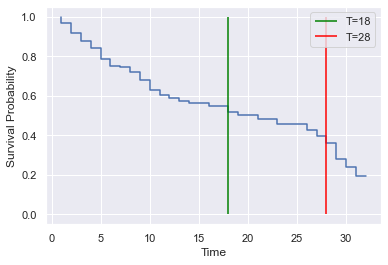

[0.0288792  1.00726577] [0.8555637  0.66270139]


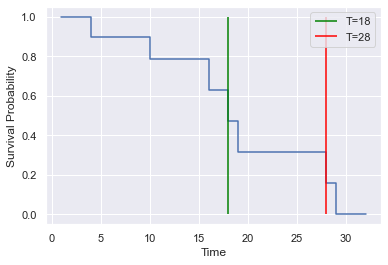

In [134]:
kmf1 = KaplanMeierZeroAfter()
kmf1.fit(y_tr["time"], y_tr["cens"])

sf1 = kmf1.survival_function_at_times(bins_HO)
sf1 = np.repeat(sf1[np.newaxis, :], y_HO.shape[0], axis=0)

ibs1 = metr.ibs(y, y_HO, sf1, bins_HO, axis=0)
auprc1 = metr.auprc(y, y_HO, sf1, bins_HO, axis=0)
print(ibs1[[24, 42]], auprc1[[24, 42]])
plt.step(bins_HO, sf1[0])
plt.vlines(y_HO[[24]]["time"], ymin=0, ymax=1, color="green", label="T=18")
plt.vlines(y_HO[[42]]["time"], ymin=0, ymax=1, color="red", label="T=28")
plt.ylim([-0.05, 1.05])
plt.ylabel("Survival Probability")
plt.xlabel("Time")
plt.legend()
plt.show()

kmf1 = KaplanMeierZeroAfter()
kmf1.fit(y_tr["time"][10:20], y_tr["cens"][10:20])

sf1 = kmf1.survival_function_at_times(bins_HO)
sf1 = np.repeat(sf1[np.newaxis, :], y_HO.shape[0], axis=0)

ibs1 = metr.ibs(y, y_HO, sf1, bins_HO, axis=0)
auprc1 = metr.auprc(y, y_HO, sf1, bins_HO, axis=0)
print(ibs1[[24, 42]], auprc1[[24, 42]])
plt.step(bins_HO, sf1[0])
plt.vlines(y_HO[[24]]["time"], ymin=0, ymax=1, color="green", label="T=18")
plt.vlines(y_HO[[42]]["time"], ymin=0, ymax=1, color="red", label="T=28")
plt.ylim([-0.05, 1.05])
plt.ylabel("Survival Probability")
plt.xlabel("Time")
plt.legend()

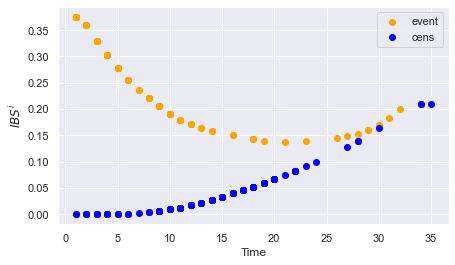

In [127]:
sf1 = kmf1.survival_function_at_times(bins_HO)
sf1 = np.repeat(sf1[np.newaxis, :], y_tr.shape[0], axis=0)

ibs1 = metr.ibs_WW(y, y_tr, sf1, bins_HO, axis=0)
plt.figure(figsize=(7, 4))
plt.scatter(y_tr["time"][y_tr["cens"] == 1], ibs1[y_tr["cens"] == 1], c="orange", label="event")
plt.scatter(y_tr["time"][y_tr["cens"] == 0], ibs1[y_tr["cens"] == 0], c="blue", label="cens")
# plt.ylim([-0.05, 1.05])
# plt.ylabel(r"$AUPRC$")
plt.ylabel(r"$IBS^i$")
plt.xlabel("Time")
plt.legend()
plt.show()

In [61]:
# y_HO[38]  # 0, 8, 32, 38, 
y_HO[24]

(False, 18.)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


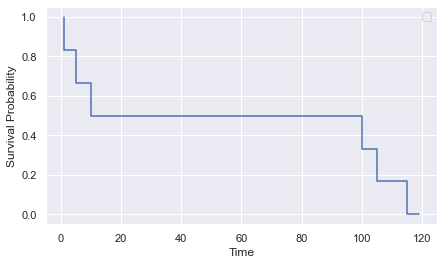

In [133]:
kmf1 = KaplanMeierZeroAfter()
kmf1.fit(np.array([1, 5, 10, 100, 105, 115]), np.array([1, 1, 1, 1, 1, 1]))

plt.figure(figsize=(7, 4))
sf1 = kmf1.survival_function_at_times(np.arange(1, 120))
plt.step(np.arange(1, 120), sf1)
plt.ylim([-0.05, 1.05])
plt.ylabel("Survival Probability")
plt.xlabel("Time")
plt.legend()
plt.show()

In [ ]:
plt.scatter(y["time"], ibs_full1, s=np.where(y["cens"], 20, 3))
plt.scatter(y["time"], ibs_full2, s=np.where(y["cens"], 20, 3))

In [ ]:
pred_haz.shape, pred_surv.shape, pred_time.shape

In [ ]:
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

tree_m = CRAID(features=features, criterion="logrank", depth=10, min_samples_leaf=0.05)
tree_m.fit(X_tr, y_tr)

pred_time = tree_m.predict(X_HO, target="time")
pred_surv = tree_m.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = tree_m.predict_at_times(X_HO, bins=bins_HO, mode="hazard")
print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_WW", "IBS_REMAIN", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))
tree_m.visualize(mode="surv")

In [ ]:
tree_m = CRAID1(features=features, max_features=10, criterion="ibswei", depth=10, min_samples_leaf=0.05, n_jobs=1)
tree_m.fit(X_tr, y_tr)

pred_time1 = tree_m.predict(X_HO, target="time")
pred_surv1 = tree_m.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz1 = tree_m.predict_at_times(X_HO, bins=bins_HO, mode="hazard")
print(count_metric(y_tr, y_HO, pred_time1,
                   pred_surv1, pred_haz1, bins_HO, 
                   ['CI', "IBS_WW", "IBS_REMAIN", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

In [ ]:
times = bins_HO
time = y_HO[[3]]["time"]
event = y_HO[[3]]["cens"]
estimate = pred_surv[[3]]

steps = np.linspace(1e-5, 1 - 1e-5, 100)
before_time = np.dot(time[:, np.newaxis], steps[np.newaxis, :])
after_time = np.dot(time[:, np.newaxis], 1 / steps[np.newaxis, :])
before_ind = np.clip(np.searchsorted(times, before_time), 0, times.shape[0] - 1)
after_ind = np.clip(np.searchsorted(times, after_time), 0, times.shape[0] - 1)

est1 = np.take_along_axis(estimate, before_ind, axis=1)
est2 = np.take_along_axis(estimate, after_ind, axis=1)

np.trapz(est1[0], steps), np.trapz(est2[0], steps)

In [ ]:
np.trapz(estimate[0][before_ind[0]], steps)

In [ ]:
np.trapz(estimate[0][bins_HO < time[0]], bins_HO[bins_HO < time[0]]) / time[0]

In [ ]:
param_bstr = {'aggreg_func': 'mean', 'all_weight': True, 'balance': None, 'categ': categ, 
        'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
        'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.01, # 0.01 
        'n_estimators': 100, 'n_jobs': 5, 'size_sample': 0.7}

bstr = IBSCleverBoostingCRAID1(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time = bstr.predict(X_HO, target="time")
pred_surv = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = bstr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

In [ ]:
[0.63013484 0.1418403 0.34070651 0.76727171 0.69328389 0.51621181
 0.67322494]

In [353]:
from survivors.ensemble import BootstrapCRAID
param_bstr = {'balance': None, 'categ': categ, 
        'criterion': 'logrank', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
        'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, # 0.01 
        'n_estimators': 50, 'n_jobs': 1, 'size_sample': 0.7}

bstr = BootstrapCRAID1(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time = bstr.predict(X_HO, target="time")
pred_surv = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = bstr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

fitted: 50 models.
[0.1469 0.1322 0.1199 0.1123 0.1016 0.1007 0.0937 0.0896 0.0862 0.088
 0.0882 0.0855 0.086  0.0858 0.0846 0.0835 0.0831 0.0813 0.0822 0.0823
 0.0834 0.0828 0.0822 0.0833 0.0821 0.0812 0.0808 0.0801 0.0806 0.0796
 0.0787 0.0789 0.0795 0.0796 0.0803 0.0801 0.0805 0.0798 0.0794 0.0793
 0.0801 0.0801 0.0795 0.0791 0.0793 0.0795 0.0793 0.0793 0.0793 0.0791]
fitted: 31 models.
[0.76387937 0.07753413 0.16942422 0.8413846  0.74359132 0.53052464
 0.73067819]


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls


In [ ]:
[0.76949966 0.0731472  0.15095689 0.88009556 0.7402209  0.52555925
 0.7272111 ]

In [ ]:
[0.76374229 0.0724249  0.15308184 0.84404132 0.7510269  0.53284779
 0.73780392]

In [ ]:
[0.75647704 0.07440434 0.14089191 0.82256798 0.74812744 0.52547237
 0.73463319]

In [ ]:
[0.75209047 0.07015576 0.14000836 0.86721855 0.75172031 0.53502884
 0.7385875 ]

In [10]:
pred_0_numb = bstr.models[1].predict(X_HO, target="numb")
pred_0_time = bstr.models[1].predict(X_HO, target="time")

In [11]:
a = np.bincount(pred_0_numb.astype(int), weights=pred_0_time) / np.bincount(pred_0_numb.astype(int))

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_22860\2244739613.py:1: RuntimeWarning: invalid value encountered in divide
  a = np.bincount(pred_0_numb.astype(int), weights=pred_0_time) / np.bincount(pred_0_numb.astype(int))


Text(0, 0.5, 'Mean leaf time')

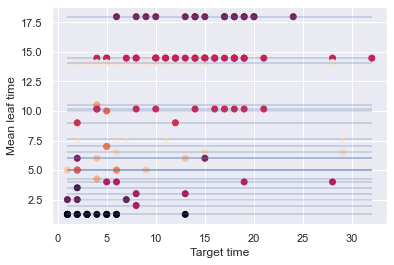

In [14]:
plt.scatter(y_HO["time"], pred_0_time, c=pred_0_numb)
plt.hlines(y=[a], xmin=y_HO["time"].min(), xmax=y_HO["time"].max(), alpha=0.3)
plt.xlabel("Target time")
plt.ylabel("Mean leaf time")

In [86]:
X_tr.index

Index([310, 288, 204, 274, 145, 243,  73, 212, 366, 338,
       ...
       318, 315, 114,  85, 371, 230,  18, 119,   6, 141],
      dtype='int64', length=251)

In [87]:
X_tr

,min_ferritin,min_mean_corpuscular_volume,min_Fibrin_degradation_products,min_glutamic_pyruvic_transaminase,max_RBC_distribution_width_SD,min_D_D_dimer,mean_Red_blood_cell_count,min_Platelet_count,min_basophil___,min_International_standard_ratio,...,max_Direct_bilirubin,min_eosinophils___,max_Interleukin_1_,min_creatinine,mean_Interleukin_6,max_Urea,max_mean_corpuscular_volume,min_monocytes___,min_Hypersensitive_c_reactive_protein,max_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_
310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204,NaN,87.1,25.8,15.0,44.9,6.75,3.113333,80.0,0.1,1.11,...,5.4,0.0,18.6,220.0,280.80,30.9,88.9,1.9,139.7,560.0
274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,417.6,88.0,4.0,15.0,41.5,0.48,9.324000,168.0,0.1,0.91,...,6.7,0.0,39.8,55.0,21.09,9.7,89.3,2.3,0.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,3561.4,93.4,150.0,31.0,50.2,2.15,8.730000,10.0,0.1,1.15,...,41.7,0.0,5.0,76.0,18.30,15.2,100.8,1.3,26.2,4177.0
18,2341.2,98.1,4.0,16.0,57.8,1.23,5.562000,105.0,0.4,0.99,...,7.0,0.2,5.0,63.0,3.08,7.5,99.7,12.4,1.6,214.0
119,1736.4,85.7,NaN,66.0,38.3,3.23,4.175000,231.0,0.2,0.99,...,6.8,0.6,6.0,64.0,89.09,6.1,87.4,10.4,42.3,125.0
6,417.9,85.4,4.0,16.0,40.3,0.31,5.225000,200.0,0.0,0.84,...,8.4,0.0,5.0,61.0,37.30,6.5,92.1,4.2,1.5,9.0


In [89]:
bstr.oob_index[0]

array([  2,   3,   4,   5,   7,   8,  10,  12,  13,  15,  16,  18,  19,
        20,  22,  24,  26,  27,  30,  33,  37,  40,  44,  45,  46,  51,
        52,  54,  55,  56,  59,  60,  61,  63,  64,  66,  71,  73,  74,
        75,  76,  80,  83,  86,  89,  90,  92,  96,  97, 101, 104, 106,
       107, 108, 109, 110, 111, 116, 118, 122, 124, 125, 126, 129, 134,
       135, 136, 137, 139, 144, 145, 146, 150, 152, 153, 154, 156, 157,
       158, 159, 160, 161, 166, 168, 171, 173, 176, 179, 181, 182, 184,
       188, 189, 190, 191, 194, 198, 199, 200, 206, 210, 212, 213, 214,
       215, 217, 218, 219, 220, 221, 223, 224, 225, 226, 228, 229, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 245, 246, 247, 248, 249,
       250], dtype=int64)

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_22860\2331054030.py:14: RuntimeWarning: invalid value encountered in divide
  a = np.bincount(pred_0_size.astype(int), weights=ibss) / np.bincount(pred_0_size.astype(int))


corr: -0.2648374213483273
p-value: 0.034441554521154466


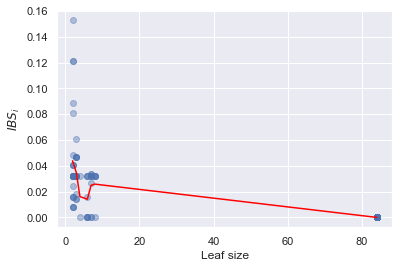

In [117]:
from scipy.stats import spearmanr

X_ = X_tr.reset_index(drop=True)

ind = 3
X_sub = X_.loc[X_.index.difference(bstr.oob_index[ind]), :]
y_sub = y_tr[X_.index.difference(bstr.oob_index[ind])]

pred_0_time = bstr.models[ind].predict(X_sub, target="time")
pred_0_size = bstr.models[ind].predict(X_sub, target="size")
pred_0_surv = bstr.models[ind].predict_at_times(X_sub, bins=bins_HO, mode="surv")

ibss = metr.ibs_WW(y_tr, y_sub, pred_0_surv, bins_HO, axis=0)
a = np.bincount(pred_0_size.astype(int), weights=ibss) / np.bincount(pred_0_size.astype(int))

plt.scatter(pred_0_size, ibss, alpha=0.4)
plt.plot(np.unique(pred_0_size), a[~np.isnan(a)], color="red")
plt.xlabel("Leaf size")
plt.ylabel(r"$IBS_i$")

rho, p = spearmanr(ibss[pred_0_size < 30], pred_0_size[pred_0_size < 30])
print("corr:", rho)
print("p-value:", p)

(array([4., 5., 6., 0., 0., 2., 1., 0., 0., 2.]),
 array([ 2. ,  4.7,  7.4, 10.1, 12.8, 15.5, 18.2, 20.9, 23.6, 26.3, 29. ]),
 <BarContainer object of 10 artists>)

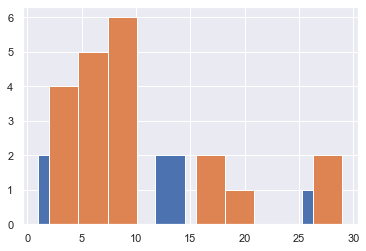

In [120]:
plt.hist(y_HO["time"][:10])
plt.hist(y_HO["time"][20:20])

In [305]:
from scipy.stats import ranksums, kstest, mannwhitneyu

ranksums(y_HO["time"][y_HO["time"] > 20], y_HO["time"][y_HO["time"] < 20])[0]

5.226573750625902

In [341]:
mannwhitneyu(y_HO["time"][y_HO["time"] > 10], y_HO["time"][y_HO["time"] < 10])

MannwhitneyuResult(statistic=3472.0, pvalue=7.353581635369584e-21)

In [180]:
a = np.array([0, 1, 0, 1, 0, 1])
b = np.array([0, 0, 0, 1, 1, 1])
rank = np.arange(1, a.shape[0] + 1)
np.dot(a, rank) / np.sum(a)

4.0

In [314]:
from scipy.stats import rankdata

def ranksums_hist(x, y):
    n1 = np.sum(x)
    n2 = np.sum(y)
    rank = np.arange(1, x.shape[0] + 1)
    s = np.dot(x, rank)
    print(s)
    expected = n1 * (n1+n2+1) / 2.0
    z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
    return z

def ranksums(hx, hy):
    x = np.repeat(np.arange(1, hx.size + 1), hx.astype(int))
    y = np.repeat(np.arange(1, hy.size + 1), hy.astype(int))
    print(x)
    x, y = map(np.asarray, (x, y))
    n1 = x.shape[0]
    n2 = y.shape[0]
    alldata = np.concatenate((x, y))
    ranked = rankdata(alldata)
    print(ranked)
    x = ranked[:n1]
    s = np.sum(x, axis=0)
    print(s)
    expected = n1 * (n1+n2+1) / 2.0
    z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
    return z

In [315]:
ranksums_hist(np.array([1, 1, 0, 0, 3, 0, 0]), 
         np.array([0, 0, 1, 1, 0, 0, 1]))

18


-1.3416407864998738

In [316]:
ranksums(np.array([1, 1, 0, 0, 3, 0, 0]), 
         np.array([0, 0, 1, 1, 0, 0, 1]))

[1 2 5 5 5]
[1. 2. 6. 6. 6. 3. 4. 8.]
21.0


-0.4472135954999579

In [ ]:
[0.7560658  0.07472069 0.14080596 0.83685749 0.74843625 0.52911954
 0.73514433]

In [ ]:
[0.76100069 0.07011951 0.12759118 0.87563497 0.74828594 0.51627036
 0.73422439]

In [ ]:
[0.77087046 0.0714181  0.13772382 0.87419811 0.7440283  0.51076982
 0.72989142]

In [ ]:
[0.75030843 0.07748653 0.1448151  0.82615882 0.74452061 0.5191674
 0.73086284]
[0.76703221 0.07544973 0.14209613 0.85055543 0.74599572 0.52798263
 0.73278281]  # only_log_rank

In [ ]:
[0.75058259 0.87791219 0.07801019 0.18533862 0.88196739 0.75960723
 0.55266705 0.7470654 ]

[0.75277587 0.88149642 0.07252386 0.16060168 0.86366427 0.76527479
 0.5589904  0.75277271]

In [ ]:
y_HO[np.argsort(a)[:10]]

In [ ]:
a = metr.auprc(y_tr, y_HO, st, bins_HO, axis=0)
plt.plot(np.sort(a))
plt.hlines(y=[np.median(a)], xmin=0, xmax=a.shape[0], color="green")
plt.hlines(y=[np.mean(a)], xmin=0, xmax=a.shape[0], color="red")

In [ ]:
[0.63302716 0.13979877 0.33711561 0.77352287 0.69542915 0.51581538
 0.67508228]

In [ ]:
[0.628376   0.14211706 0.34293727 0.7677789  0.69501956 0.51565712
 0.67470116]

In [ ]:
[0.62888411 0.14833584 0.34296446 0.76911903 0.70039634 0.46559482
 0.67379773]

In [ ]:
st = bstr.models[0].predict_at_times(X_HO, bins=bins_HO, mode="surv")
num = bstr.models[0].predict(X_HO, target="numb").astype('int')
ibss = metr.ibs_WW(y_tr, y_HO, st, bins_HO, axis=0)

a = np.bincount(num, weights=ibss)/np.bincount(num)
print(a)
np.argsort(np.nan_to_num(a, 0))

In [ ]:
leaf_numb = 100
y_tr[bstr.models[0].predict(X_tr, target="numb").astype('int') == leaf_numb], y_HO[num == leaf_numb], ibss[num == leaf_numb]

In [87]:
bstr.models[0].visualize(mode="surv")

In [ ]:
bstr.models[0].nodes[leaf_numb].leaf_model.lists["time"], bstr.models[0].nodes[leaf_numb].leaf_model.lists["cens"]

In [ ]:
kmf = KaplanMeierZeroAfter()
kmf.fit(np.array([1703.0, 2175.0, 692.0, 2175.0]), np.array([1, 1, 1, 1]))
kmf.survival_function

kmf1 = KaplanMeierZeroAfter()
kmf1.fit(np.array([1703.0, 2175.0, 692.0, 2175.0]), np.array([0, 0, 0, 0]))
kmf.survival_function*0.5 + kmf1.survival_function*0.5

In [ ]:
plt.step(bins_HO, bstr.models[0].nodes[leaf_numb].leaf_model.predict_survival_at_times(X=None, bins=bins_HO))

In [ ]:
bstr.models[0].nodes[110].get_full_rule()

In [ ]:
[0.63447332 0.14794288 0.34201422 0.76260881 0.70294555 0.46961011
 0.67651302]

In [ ]:
[0.63552863 0.1460382  0.33880928 0.7713849  0.70406205 0.46900253
 0.67743421]

In [ ]:
[0.62571819 0.14431613 0.34435273 0.76853784 0.69823154 0.47693504
 0.6731628 ]

In [ ]:
[0.63537229 0.14244827 0.33418399 0.76911905 0.69135619 0.46550928
 0.66577197]

In [ ]:
[0.63005667 0.14378532 0.33457048 0.76142872 0.69421038 0.4725349
 0.66909871]

In [ ]:
param_bstr = {'balance': None, 'categ': categ, 
    'criterion': 'ibswei', 'depth': 10, 'ens_metric_name': 'IBS_WW', 
    'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, # 0.01 
    'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}

bstr1 = BootstrapCRAID(**param_bstr)
bstr1.fit(X_tr, y_tr)
bstr1.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time1 = bstr1.predict(X_HO, target="time")
pred_surv1 = bstr1.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz1 = bstr1.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time1,
                   pred_surv1, pred_haz1, bins_HO, 
                   ['CI', "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

In [ ]:
[0.61708032 0.10647576 0.14558612 0.66939811 0.49017465 0.64909545]


In [ ]:
[0.62431112 0.10494258 0.14357879 0.66784064 0.4888831  0.64756811]


In [ ]:
plt.scatter(y_HO["time"], metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0))
plt.scatter(y_HO["time"], metr.ibs_WW(y_tr, y_HO, pred_surv1, bins_HO, axis=0))

In [ ]:
plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0),
            metr.ibs_WW(y_tr, y_HO, pred_surv1, bins_HO, axis=0))

In [ ]:
from survivors.ensemble import ProbBoostingCRAID
param_bstr = {'aggreg_func': 'wei', "with_arc": False, 
              'balance': None, 'categ': categ, "all_weight": True, 
                'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_WW', 
                'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, # 0.01 
                'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}
prbst = ProbBoostingCRAID(**param_bstr)
prbst.fit(X_tr, y_tr)
prbst.tolerance_find_best(param_bstr["ens_metric_name"])
pr_pred_time = prbst.predict(X_HO, target="time")
pr_pred_surv = prbst.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pr_pred_haz = prbst.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pr_pred_time,
                   pr_pred_surv, pr_pred_haz, bins_HO, 
                   ['CI', "IBS_WW", "IBS_REMAIN", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

In [ ]:
from survivors.ensemble import BoostingCRAID
param_bstr = {'aggreg_func': 'wei', "with_arc": False, 'weighted_tree': False,
              'balance': None, 'categ': categ, "all_weight": False, "mode_wei": 'square',
                'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_WW', 
                'leaf_model': 'base_fast', 'max_features': 0.3, 'min_samples_leaf': 0.001, # 0.01 
                'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}
prbst = BoostingCRAID(**param_bstr)
prbst.fit(X_tr, y_tr)
prbst.tolerance_find_best(param_bstr["ens_metric_name"])
pr_pred_time = prbst.predict(X_HO, target="time")
pr_pred_surv = prbst.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pr_pred_haz = prbst.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pr_pred_time,
                   pr_pred_surv, pr_pred_haz, bins_HO, 
                   ['CI', "IBS_WW", "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

In [11]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
param_est = {'learning_rate': 0.05, 'loss': 'coxph', 
              'max_depth': 20, 'max_features': 'sqrt', 
              'min_samples_leaf': 20, 'n_estimators': 50, 'random_state': 123}

est = GradientBoostingSurvivalAnalysis(**param_est)
X_tr_sks = X_tr.fillna(0).replace(np.nan, 0)
X_HO_sks = X_HO.fillna(0).replace(np.nan, 0)

est = est.fit(X_tr_sks, y_tr)
survs = est.predict_survival_function(X_HO_sks)
hazards = est.predict_cumulative_hazard_function(X_HO_sks)
pred_surv_bstr = np.array(list(map(lambda x: x(bins_HO), survs)))
pred_haz_bstr = np.array(list(map(lambda x: x(bins_HO), hazards)))
pred_time_bstr = -1*est.predict(X_HO_sks)

print(count_metric(y_tr, y_HO, pred_time_bstr,
                   pred_surv_bstr, pred_haz_bstr, bins_HO, 
                   ['CI', "CI_CENS", "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

[0.72919808 0.85640681 0.09240043 0.21129718 0.84030537 0.65518371
 0.41999913 0.6409301 ]


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls


In [ ]:
[0.61959187 0.15830578 0.3311214  0.75086706 0.64686629 0.41465875
 0.61896538]

In [ ]:
d = dict(zip(features, est.feature_importances_))
d_ = dict(sorted(d.items(), key=lambda item: -item[1]))
d_

In [ ]:
ibs_vals = metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)
plt.scatter(y_HO["time"], ibs_vals, c=np.where(y_HO["cens"], "orange", "blue"))
plt.title("TRAIN")
plt.xlabel("Time")
plt.ylabel("IBS_REMAIN")
print(np.mean(ibs_vals), np.std(ibs_vals))
plt.show()

ibs_vals = metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0)
plt.scatter(y_HO["time"], ibs_vals, c=np.where(y_HO["cens"], "gold", "darkblue"))
plt.title("TEST")
plt.xlabel("Time")
plt.ylabel("IBS_REMAIN")
plt.show()
print(np.mean(ibs_vals), np.std(ibs_vals))

In [ ]:
param = {'aggreg_func': 'mean', 'weighted_tree': False,
         'balance': None, 'categ': categ, 'all_weight': True,  # "only_log_rank"
         'criterion': 'peto', 'depth': 7, 'ens_metric_name': 'IBS_WW', 
         'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.05, 
         'n_estimators': 50, 'n_jobs': 1, 'size_sample': 0.5}

# param = {'aggreg_func': 'wei', 'weighted_tree': False,
#          'balance': None, 'categ': categ, 'all_weight': True,  # "only_log_rank"
#          'criterion': 'peto', 'depth': 7, 'ens_metric_name': 'IBS_REMAIN', 
#          'leaf_model': 'base_fast', 'max_features': 0.3, 'min_samples_leaf': 0.05, 
#          'n_estimators': 50, 'n_jobs': 1, 'size_sample': 1.0}

bst = IBSCleverBoostingCRAID1(**param)
bst.fit(X_tr, y_tr)
# bst.tolerance_find_best(param["ens_metric_name"])

pred_surv = bst.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_time = bst.predict(X_HO, target=cnt.TIME_NAME)
pred_haz = bst.predict_at_times(X_HO, bins=bins_HO, mode="hazard")
print(count_metric(y_tr, y_HO, pred_time, 
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

In [ ]:
[0.76004112 0.08142023 0.15725193 0.82522674 0.74669112 0.5263278
 0.73333577]

In [ ]:
[0.74530257 0.0898127  0.20803243 0.89115491 0.71697038
 0.45596368 0.68388502]

In [ ]:
[0.74804607 0.08801539 0.18134788 0.83107438 0.70331706 0.43851512 0.68726846]

In [ ]:
[0.74489236 0.08457115 0.14168006 0.85179607 0.72299419 0.46876279 0.70758623]

In [ ]:
[0.6281024  0.10568593 0.14523742 0.35297625 0.75068269 0.70383533
 0.52024883 0.68303842]

In [ ]:
[0.62337307 0.10386134 0.14200631 0.38739308 0.76488304 0.68675712
 0.51934772 0.66779278]

In [ ]:
[0.628376   0.10954972 0.14885949 0.42151545 0.75263177 0.72983042
 0.54319429 0.70868805]



In [ ]:
[0.62767246 0.10946605 0.14872402 0.41986858 0.75285723 0.72985129
 0.54328022 0.70871629]

In [ ]:
[0.63040844 0.10627041 0.14539301 0.37721831 0.75708808 0.71503153
 0.53049403 0.69412689]

In [ ]:
[0.62884503 0.12118926 0.16319798 0.44877019 0.74167396 0.74745494
 0.53584763 0.7234838 ]

In [ ]:
[0.67986326 0.10607445 0.13573885 0.50670191 0.77434917 0.74461208
 0.49396821 0.71244981]

In [ ]:
[0.62528825 0.10841821 0.14737888 0.38667048 0.74371303 0.73301454
 0.53644526 0.71074692]

In [ ]:
[0.62747704 0.10943691 0.148753 0.407465 0.75551115 0.73796047 0.54631429 0.71625056]

In [ ]:
# 500 trees with (ibs + 0.01)**2

[0.62728161 0.11491767 0.15558508 0.4369346  0.75162291 0.74540918
 0.55013961 0.7232888 ]

In [ ]:
ind = 9
print(y_HO[ind])
plt.step(bins_HO, pred_surv_bstr[ind])
plt.step(bins_HO, pred_surv[ind])

In [ ]:
bins_HO

In [ ]:
[0.6270471  0.10445372 0.14307231 0.36536187 0.75919258 0.72271412
 0.54059226 0.70208313]

In [ ]:
[0.61829197 0.10674626 0.14629515 0.37302563 0.75679989 0.72305381
 0.54106211 0.70243756]

In [ ]:
[0.77607951 0.05217564 0.07227308 0.13924877 0.86552461 0.70292791
 0.42100231 0.68584151]

In [ ]:
[0.76566141 0.05515452 0.07489702 0.1462262  0.86473855 0.70503936
 0.41670694 0.68756467]

In [ ]:
[0.7601782  0.04886587 0.06888839 0.12813492 0.90029203 0.67683953
 0.3892159  0.65940779]

In [ ]:
[0.80911583 0.04892541 0.06904    0.12325186 0.88567412 0.67987295
 0.3925011  0.66245647]

In [ ]:
df[df["min_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_"] > 473][["min_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_", "cens"]]

In [ ]:
sorted(bst.models[0].nodes[0].leaf_model.lists["time"])

In [ ]:
d = bst.models[0].nodes[25].leaf_model.lists
dt = np.array(d["time"])
dc = np.array(d["cens"])

km = KaplanMeierFitter()
km.fit(dt, dc)
km.plot()

dt[np.where(dc == 0)] = 500

km = KaplanMeierFitter()
km.fit(dt, dc)
km.plot()

In [ ]:
for i in range(len(bst.models[0].nodes)):
    print(i, bst.models[0].nodes[i].get_full_rule())

In [ ]:
dt[np.where(dc == 0)]

In [ ]:
bst.models[0].visualize(mode="surv")

In [ ]:
[0.80911583 0.04892541 0.06904    0.12325186 0.88567412 0.67987295
 0.3925011  0.66245647]

[0.81034955 0.04914468 0.06954718 0.12530352 0.88259484 0.67759486
 0.38931385 0.66012328]

In [ ]:
[0.62278679 0.10448363 0.14378023 0.33201395 0.7578171  0.69019376
 0.51303588 0.67012509]

In [ ]:
param = {'aggreg_func': 'wei', 'weighted_tree': True,
         'balance': None, 'categ': categ, 'all_weight': True,  # "only_log_rank"
         'criterion': 'weights', 'depth': 7, 'ens_metric_name': 'IBS_REMAIN', 
         'leaf_model': 'base_fast', 'max_features': 0.3, 'min_samples_leaf': 0.05, 
         'n_estimators': 100, 'n_jobs': 1, 'size_sample': 1.0}

[0.81172036 0.04935577 0.06994577 0.12587805 0.88561388 0.67656763
 0.38859076 0.65911449]

In [ ]:
[0.79718986 0.04992077 0.07067745 0.12626976 0.87837713 0.6817066
 0.39409409 0.66427554]

In [ ]:
plt.plot(np.cumsum(np.ones_like(bst.bettas)) / np.cumsum(bst.bettas))

In [ ]:
axx = 1
for mtr in ["ibs_REMAIN", "CI_CENS", "IAUC_WW_TI", "AUPRC"]:
    bst.plot_curve(X_tr, y_tr, bins_HO, "train", mtr, axes=axx)
    bst.plot_curve(X_HO, y_HO, bins_HO, "test", mtr, axes=axx)
    plt.legend()
    plt.show()

In [ ]:
axx = None
for mtr in ["ibs_REMAIN", "AUPRC"]:
    bst.plot_curve(X_tr, y_tr, bins_HO, "train", mtr, axes=axx)
    bst.plot_curve(X_HO, y_HO, bins_HO, "test", mtr, axes=axx)
    plt.legend()
    plt.show()

In [ ]:
axx = 1
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "ibs_REMAIN", axes=axx)
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "ibs_REMAIN", axes=axx)
plt.legend()
plt.show()
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "auprc", axes=axx)
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "auprc", axes=axx)
plt.legend()
plt.show()

In [ ]:
axx = 1
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "ibs_REMAIN", axes=axx)
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "ibs_REMAIN", axes=axx)
plt.legend()
plt.show()
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "auprc", axes=axx)
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "auprc", axes=axx)
plt.legend()
plt.show()

In [ ]:
axx = 1
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "ibs_REMAIN", axes=axx)
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "ibs_REMAIN", axes=axx)
plt.legend()
plt.show()
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "auprc", axes=axx)
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "auprc", axes=axx)
plt.legend()
plt.show()

In [ ]:
axx = None
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "ibs_REMAIN", axes=axx)
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "ibs_REMAIN", axes=axx)
plt.legend()
plt.show()
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "auprc", axes=axx)
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "auprc", axes=axx)
plt.legend()
plt.show()

In [ ]:
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "ibs")
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "ibs")
plt.legend()
plt.show()
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "auprc")
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "auprc")
plt.legend()
plt.show()

In [ ]:
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "ibs")
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "ibs")
plt.legend()
plt.show()
bst.plot_curve(X_tr, y_tr, bins_HO, "train", "auprc")
bst.plot_curve(X_HO, y_HO, bins_HO, "test", "auprc")
plt.legend()
plt.show()

In [ ]:
## [0.79520219 0.07152668 0.12995207 0.86920129 0.67270816 0.38657166 0.65536655]

In [ ]:
print(y_HO[y_HO["time"] > 25])
X_HO[(y_HO["time"] > 25) & (y_HO["cens"] == 1)].describe()

In [ ]:
X_HO[(y_HO["time"] > 25) & (y_HO["cens"] == 0)].describe()

In [ ]:
import statsmodels.api as sm

model = sm.OLS(y["cens"], X.fillna(0).replace(np.nan, 0))
results = model.fit()
results.params
results.summary()

In [ ]:
df[["mean_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_", "cens"]].value_counts()

In [ ]:
sns.scatterplot(df.reset_index(drop=True), x="mean_thrombocytocrit", y="time", palette="deep")

In [ ]:
l1 = []
l2 = []
for b in bins_HO[1:]:
    ind = np.where(y_HO["time"] <= b)
    l1.append(metr.ibs_remain(y_tr, y_HO[ind], pred_surv[ind], bins_HO))
    l2.append(metr.ibs_remain(y_tr, y_HO[ind], pred_surv_bstr[ind], bins_HO))
plt.plot(bins_HO[1:], l1)
plt.plot(bins_HO[1:], l2)

In [ ]:
[0.617393   0.14809655 0.34428443 0.75925409 0.68397882 0.50880313 0.6641347 ]

In [ ]:
[0.62384209 0.14637976 0.34313499 0.77219706 0.67969879 0.50319173 0.65970385]

In [ ]:
[0.62904045 0.14410236 0.3889508  0.75498701 0.68365474 0.5262897 0.66582823]

[0.63443424 0.14384832 0.34170951 0.76274264 0.68895888 0.50904109 0.66857756]

In [ ]:
# [0.80020562 0.06946576 0.12550715 0.88966621 0.67995909 0.39606099
#  0.66275315]

# [0.80089102 0.06919537 0.12511141 0.89019215 0.68100682 0.39766488
#  0.66383458]

In [ ]:
[0.80089102 0.06919537 0.12511141 0.89019215 0.68100682 0.39766488 0.66383458]

[0.80020562 0.12550715 0.88966621 0.67995909 0.39606099 0.66275315]

In [ ]:
ibs_vals = metr.ibs_remain(y_tr, y_HO, pred_surv, bins_HO, axis=0)
plt.scatter(y_HO["time"], ibs_vals, c=np.where(y_HO["cens"], "orange", "blue"))
plt.title("TEST")
plt.xlabel("Time")
plt.ylabel("IBS_WW")
plt.show()
print(np.mean(ibs_vals), np.std(ibs_vals))

pred_sv_tr = bst.predict_at_times(X_tr, bins=bins_HO, mode="surv")
ibs_vals = metr.ibs_remain(y_tr, y_tr, pred_sv_tr, bins_HO, axis=0)
plt.scatter(y_tr["time"], ibs_vals, c=np.where(y_tr["cens"], "orange", "blue"))
plt.title("TRAIN")
plt.xlabel("Time")
plt.ylabel("IBS_WW")
print(np.mean(ibs_vals), np.std(ibs_vals))

In [ ]:
ibs_vals = metr.ibs_remain(y_tr, y_HO, pred_surv, bins_HO, axis=0)
plt.scatter(y_HO["time"], ibs_vals, c=np.where(y_HO["cens"], "orange", "blue"))
plt.show()
print(np.mean(ibs_vals), np.std(ibs_vals))

pred_sv_tr = bst.predict_at_times(X_tr, bins=bins_HO, mode="surv")
ibs_vals = metr.ibs_remain(y_tr, y_tr, pred_sv_tr, bins_HO, axis=0)
plt.scatter(y_tr["time"], ibs_vals, c=np.where(y_tr["cens"], "orange", "blue"))
print(np.mean(ibs_vals), np.std(ibs_vals))

In [ ]:
ibs_vals = metr.ibs_remain(y_tr, y_HO, pred_surv, bins_HO, axis=0)
plt.scatter(y_HO["time"], ibs_vals, c=np.where(y_HO["cens"], "orange", "blue"))
plt.show()
print(np.mean(ibs_vals), np.std(ibs_vals))

pred_sv_tr = bst.predict_at_times(X_tr, bins=bins_HO, mode="surv")
ibs_vals = metr.ibs_remain(y_tr, y_tr, pred_sv_tr, bins_HO, axis=0)
plt.scatter(y_tr["time"], ibs_vals, c=np.where(y_tr["cens"], "orange", "blue"))
print(np.mean(ibs_vals), np.std(ibs_vals))

In [ ]:
ibs_vals = metr.ibs_remain(y_tr, y_HO, pred_surv, bins_HO, axis=0)
plt.scatter(y_HO["time"], ibs_vals, c=np.where(y_HO["cens"], "orange", "blue"))
plt.show()
print(np.mean(ibs_vals), np.std(ibs_vals))

pred_sv_tr = bst.predict_at_times(X_tr, bins=bins_HO, mode="surv")
ibs_vals = metr.ibs_remain(y_tr, y_tr, pred_sv_tr, bins_HO, axis=0)
plt.scatter(y_tr["time"], ibs_vals, c=np.where(y_tr["cens"], "orange", "blue"))
print(np.mean(ibs_vals), np.std(ibs_vals))

In [ ]:
ibs_vals = metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0)
plt.scatter(y_HO["time"], ibs_vals, c=np.where(y_HO["cens"], "orange", "blue"))
print(np.mean(ibs_vals), np.std(ibs_vals))

In [ ]:
GBSG 0.10520 0.09359

In [ ]:
[0.62458472 0.14642696 0.33393545 0.77167726 0.68903982 0.50546998 0.6682448 ]

[0.61219465 0.14676605 0.3704488  0.75069901 0.68089246 0.51223358 0.66178657]

In [ ]:
[0.62454563 0.16316924 0.31681772 0.76381182 0.68671327 0.48745588 0.66414114] # wei base_fast
[0.61864374 0.16558463 0.31666503 0.76349835 0.68477513 0.48610323 0.66226933] # mean base_fast

[0.62532734 0.14605382 0.33177793 0.76701593 0.68692525 0.50427755 0.66623469] # mean base_zero_after
[0.62161423 0.14433037 0.33712839 0.77097816 0.68708272 0.50941252 0.66695602] # wei base_zero_after

In [ ]:
for m_i, b in enumerate(bst.models):
    l = []
    for i, n in b.nodes.items():
        if n.is_leaf:
            l.append(n.leaf_model.shape[0])
    
    plt.scatter(x=np.ones_like(l)*m_i, y=l)

In [ ]:
for m_i, b in enumerate(bst.models):
    l = []
    for i, n in b.nodes.items():
        if n.is_leaf:
            l.append(n.leaf_model.shape[0])
    
    plt.scatter(x=np.ones_like(l)*m_i, y=l)

In [ ]:
[0.78265936 0.19179243 0.85868291 0.65793649 0.36772733 0.64034806]
[0.78457848 0.13934414 0.87004602 0.65747228 0.36876048 0.63997459]

[0.80020562 0.12550715 0.88966621 0.67995909 0.39606099 0.66275315]

In [ ]:
[0.62016807 0.31981274 0.7676767  0.67971621 0.48581002 0.65775028] # base_fast with partial ens ibs as wei
[0.61031855 0.3421834  0.75881519 0.68310193 0.50573737 0.66300985] # base_zero_after with partial ens ibs as wei

In [ ]:
[0.6227477  0.31638412 0.77072591 0.68433562 0.48604648 0.66187318] # base_fast with mean ens ibs as wei
[0.62149697 0.33383418 0.77246182 0.68627578 0.50415848 0.6656453 ] # base_zero_after with mean ens ibs as wei

In [ ]:
[0.61872191 0.33394521 0.76483232 0.68241727 0.49935149 0.66167935]

In [ ]:
x = np.hstack([np.linspace(10, 1, 50), np.linspace(1, 5, 50)])
plt.plot(x)
plt.plot(np.cumsum(x[::-1])[::-1])

In [ ]:
from scipy.optimize import linprog

obj = [0.3, 0.4, 0.77, 0.1, 0.2]

lhs_ineq = []  # левая сторона желтого неравенства
rhs_ineq = []

lhs_eq = [np.ones(len(obj))]  # левая сторона зеленого равенства
rhs_eq = [1]       # правая сторона зеленого равенства

bnd = list(zip(np.zeros(len(obj)), 
               np.ones(len(obj))))

opt = linprog(c=obj, # A_ub=lhs_ineq, b_ub=rhs_ineq,
              A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd,
              method="revised simplex")

opt

In [ ]:
n = 50

def get_sum_sqrt_rand1(ibss_):
    a = np.random.rand(n)
    a = a / np.sum(a)
    return np.sum(ibss_) * np.sum(a**2)

def get_sum_sqrt_rand2(ibss_):
    a = np.random.rand(n)
    a = a / np.sum(a)
    return np.dot(ibss_, a) * np.sum(a)

def get_sum_sqrt_rand3(ibss_):
    a = np.random.rand(n)
    a = a / np.sum(a)
    return np.dot(ibss_, a**2) * a.shape[0]

np.random.seed(100)
ibss_ = np.random.rand(n)
plt.hist([get_sum_sqrt_rand3(ibss_) for i in range(1000)])
plt.hist([get_sum_sqrt_rand2(ibss_) for i in range(1000)])
plt.hist([get_sum_sqrt_rand1(ibss_) for i in range(1000)])

In [ ]:
sfs_h = []
x_h = np.linspace(0.01, 3.0, 100)
for i in x_h:
    tm = np.clip(y[4]["time"]*i, bins_HO[0], bins_HO[-1])
    sfs_h.append(np.where(tm > bins_HO, 1, 0))

In [ ]:
sfs_v = []
x_v = np.linspace(0.0, 0.5, 100)
for i in x_v:
    sfs_v.append(np.where(y[4]["time"] > bins_HO, 1 - i, i))

In [ ]:
y_one = np.repeat(y[4], 100)

plt.scatter(x_h, metr.auprc(y_one, y_one, np.vstack(sfs_h), bins_HO, axis=0))
plt.scatter(x_h, metr.ibs_WW(y_one, y_one, np.vstack(sfs_h), bins_HO, axis=0))
plt.show()
plt.scatter(x_v, metr.auprc(y_one, y_one, np.vstack(sfs_v), bins_HO, axis=0))
plt.scatter(x_v, metr.ibs_WW(y_one, y_one, np.vstack(sfs_v), bins_HO, axis=0))
plt.show()

### Visualizations

In [ ]:
sf = np.ones((y_tr.shape[0], bins_HO.shape[0]))*0.5
sf[:, 0] = 1
sf[:, 0] = 0

# sf[:, np.where(bins_HO > 500)] = 0.75
# sf[:, np.where(bins_HO > 1000)] = 0.5
# sf[:, np.where(bins_HO > 1500)] = 0

fig, axes = plt.subplots(2, 1, figsize=(6, 8))
ibs_vals = metr.ibs_WW(y_tr, y_tr, sf, bins_HO, axis=0)
axes[0].scatter(y_tr["time"], ibs_vals, c=np.where(y_tr["cens"], "orange", "blue"))

auprc_vals = metr.auprc(y_tr, y_tr, sf, bins_HO, axis=0)
axes[1].scatter(y_tr["time"], auprc_vals, c=np.where(y_tr["cens"], "orange", "blue"))
print(np.mean(ibs_vals), np.mean(auprc_vals))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.widgets import Button, Slider
%matplotlib notebook

# The parametrized function to be plotted
def metr_vals(y_tr, bins_HO, height, time, axis=1, mtr="ibs"):
    y_tr_ = cnt.get_y(cens=[True], time=[time])
    sf = np.ones((y_tr_.shape[0], bins_HO.shape[0]))*height
    sf[:, np.where(bins_HO > time)] *= 0.9
    sf[:, np.where(bins_HO > time)] += 0.1
    sf[:, np.where(bins_HO > time)] = 0
    
    if mtr == "ibs":
        return metr.ibs_WW(y_tr_, y_tr_, sf, bins_HO, axis=axis)
    return metr.auprc(y_tr_, y_tr_, sf, bins_HO, axis=axis)

# Define initial parameters
init_time = 500
init_height = 0.5

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line,  = ax.plot(bins_HO, 
                   metr_vals(y_tr, bins_HO, init_height, init_time),) 
#                    c=np.where(y_tr["cens"], "orange", "blue"))
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(
    ax=axfreq,
    label='Time',
    valmin=bins_HO[0],
    valmax=bins_HO[-1],
    valinit=init_time,
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
height_slider = Slider(
    ax=axamp,
    label="Height",
    valmin=0,
    valmax=1,
    valinit=init_height,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    by_time = metr_vals(y_tr, bins_HO, height_slider.val, time_slider.val)
    mean_ibs = metr_vals(y_tr, bins_HO, height_slider.val, time_slider.val, axis=-1, mtr="ibs")
    mean_auprc = metr_vals(y_tr, bins_HO, height_slider.val, time_slider.val, axis=-1, mtr="auprc")
    line.set_ydata(by_time)
    ax.set_title(f'IBS:{mean_ibs:.5f}, AUPRC:{mean_auprc:.5f}')
    fig.canvas.draw_idle()


# register the update function with each slider
time_slider.on_changed(update)
height_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    time_slider.reset()
    height_slider.reset()
button.on_clicked(reset)